TensorFlow inference from a Docker TF serving server.

Launch the server with docker-compose:
    
```bash
docker-compose up
```

Then execute the code below in order to get the model metadata and to run inference on some images.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import requests
import json

host = "localhost"
port = 8501
model_name = "captchanet"
model_version = 4

In [2]:
# Get metadata about the model
request_url = f"http://{host}:{port}/v1/models/{model_name}/versions/{model_version}/metadata"
req = requests.get(request_url)
metadata = json.loads(req.text)
metadata

{'model_spec': {'name': 'captchanet', 'signature_name': '', 'version': '4'},
 'metadata': {'signature_def': {'signature_def': {'serving_default': {'inputs': {'image': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '120', 'name': ''},
         {'size': '400', 'name': ''},
         {'size': '3', 'name': ''}],
        'unknown_rank': False},
       'name': 'serving_default_image:0'}},
     'outputs': {'reshape': {'dtype': 'DT_FLOAT',
       'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
         {'size': '10', 'name': ''},
         {'size': '62', 'name': ''}],
        'unknown_rank': False},
       'name': 'StatefulPartitionedCall:0'}},
     'method_name': 'tensorflow/serving/predict'},
    '__saved_model_init_op': {'inputs': {},
     'outputs': {'__saved_model_init_op': {'dtype': 'DT_INVALID',
       'tensor_shape': {'dim': [], 'unknown_rank': True},
       'name': 'NoOp'}},
     'method_name': ''}}}}}

# TODO / WIP

In [ ]:
# Download images
batch_size = 8
captcha_url = "https://www.referendum.interieur.gouv.fr/bundles/ripconsultation/securimage/securimage_show.php"
images = [np.array(Image.open(io.BytesIO(requests.get(captcha_url).content))) for _ in trange(batch_size)]
images = np.array(images)

# Preprocess the image
batch = tf.cast(images, 'float32')
batch = tf.image.per_image_standardization(batch)

In [ ]:
# Run inference
labels = model(batch)

# Postprocess results (decode labels)
labels = tf.argmax(labels, axis=2)
labels = [tokenizer.decode(label) for label in labels]
labels = [label.replace(' ', '').replace('0', '') for label in labels]

fig_size = 2
ncols = 2
nrows = batch_size // ncols
ratio = images.shape[2] / images.shape[1]
figsize = (ncols * fig_size * ratio, fig_size * nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
axs = axs.flatten()

for image, ax, label in zip(images, axs, labels):
  ax.imshow(image)
  text = f'Predicted: {label} ({len(label)})'
  ax.set_title(text, fontsize=18)

In [21]:
# Run inference
(train_images, _), _ = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape((-1, 28, 28, 1))

i = 57074
n = 256
images = train_images[i:i+n]

dummy = np.random.randint(0, 10, size=(256, 10)).astype('int64')

# Prepare inputs
inputs_data = {"inputs": {'images': images.tolist(), 'dummy_inputs': dummy.tolist()}}

request_url = f"http://{host}:{port}/v1/models/{model_name}/versions/{model_version}:predict"
req = requests.post(request_url, json=inputs_data)
assert req.status_code == 200

outputs = json.loads(req.text)['outputs']
predicted_labels = np.argmax(outputs, axis=1)
predicted_labels

array([7, 6, 1, 1, 7, 9, 8, 5, 9, 7, 8, 9, 2, 8, 5, 6, 9, 0, 0, 8, 1, 1,
       2, 7, 7, 7, 9, 1, 4, 3, 2, 2, 5, 3, 8, 1, 7, 4, 2, 2, 4, 0, 9, 0,
       8, 7, 0, 8, 6, 4, 5, 6, 4, 4, 5, 9, 2, 3, 5, 1, 7, 4, 5, 7, 6, 2,
       6, 3, 2, 6, 2, 9, 4, 6, 9, 3, 2, 2, 9, 2, 2, 4, 5, 6, 6, 9, 1, 0,
       0, 2, 8, 5, 3, 5, 5, 1, 1, 3, 3, 3, 8, 9, 0, 9, 2, 8, 9, 7, 5, 2,
       4, 2, 0, 9, 1, 8, 1, 2, 1, 1, 3, 5, 7, 1, 6, 3, 8, 0, 0, 1, 7, 2,
       9, 3, 4, 4, 8, 7, 8, 6, 0, 9, 3, 8, 6, 9, 1, 0, 1, 1, 9, 2, 6, 3,
       9, 4, 7, 5, 5, 6, 8, 9, 2, 8, 8, 9, 9, 0, 5, 1, 1, 2, 9, 3, 5, 4,
       1, 3, 0, 6, 6, 9, 6, 2, 9, 9, 6, 0, 3, 8, 3, 3, 1, 9, 1, 5, 7, 5,
       1, 2, 9, 6, 3, 9, 3, 4, 7, 9, 7, 1, 2, 9, 2, 1, 0, 2, 9, 3, 2, 5,
       9, 9, 5, 6, 0, 9, 3, 1, 8, 1, 8, 1, 3, 2, 2, 9, 1, 3, 3, 6, 6, 9,
       9, 1, 8, 9, 5, 0, 1, 9, 9, 9, 0, 9, 4, 8])

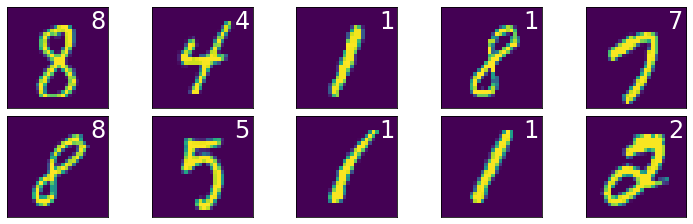

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 3), constrained_layout=True)

axs = axs.flatten()
indices = np.random.randint(0, n, size=len(axs))

for i, ax in zip(indices, axs):
    ax.imshow(images[i, :, :, 0], aspect='equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    label = predicted_labels[i]
    ax.text(0.82, 0.78, f"{label}", transform=ax.transAxes, color='white', fontsize=24)
